<a href="https://www.kaggle.com/code/yannicksteph/rsna-miccai-brain-tumor-classification?scriptVersionId=129563510" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

The RSNA-MICCAI Brain Tumor Radiogenomic Classification competition is a multi-class classification problem where the goal is to predict the subtype of brain tumor present in a given MRI scan based on radiomic features. 

There are three classes: 
- LGG (low-grade glioma)
- HGG (high-grade glioma) 
- WT (hemangioblastoma)

The dataset you will be working with consists of MRI scans from the National Cancer Institute (NCI) and The Cancer Imaging Archive (TCIA) datasets. The images are provided in DICOM format and are accompanied by a CSV file containing radiomic features extracted from the images.

Here's the competition [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data?select=train_labels.csv)

# Dataset

The exact mpMRI scans included are:
- Fluid Attenuated Inversion Recovery (FLAIR)
    * What it is: These are images that detect brain abnormalities, such as edema and inflammatory lesions. These images are sensitive to the detection of anomalies related to inflammatory and infectious diseases of the central nervous system.
    * What it highlights: It helps to detect anomalies in the brain that might not be visible in other MRI sequences.
    * These images allow for the detection of brain abnormalities related to inflammatory and infectious diseases of the central nervous system.
- T1-weighted pre-contrast (T1w)
    * What it is: These are images that highlight soft tissues, such as muscles and nerves, and are useful for visualizing normal brain structures.
    * What it highlights: It allows the visualization of the normal brain structures and also helps in the detection of tumors and lesions.
    * These images allow for the detection of brain tumors and lesions.
- T1-weighted post-contrast (T1Gd)
    * What it is: These are images that use a contrast agent to detect vascular anomalies, such as tumors and lesions, which are more visible after contrast agent administration.
    * What it highlights: It enhances the visibility of vascular anomalies, such as tumors and lesions, making it easier to detect them.
    * These images allow for the detection of vascular anomalies, such as tumors and lesions.
- T2-weighted (T2)
    * What it is: These images detect abnormalities related to demyelination, such as multiple sclerosis, as well as brain tumors and lesions.
    * What it highlights: It helps in the detection of anomalies related to cerebrospinal fluid, such as cysts and brain tumors.
    * These images allow for the detection of anomalies related to demyelination, brain tumors, lesions, and cerebrospinal fluid.

# Necessary imports

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Print indent
import json

# image dicom reader
import pydicom
from pydicom import dcmread 

warnings.filterwarnings('ignore')

# Reading Data

In [47]:
path= "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_sample_path = path + "train/"
# Dataset of the project, explanation in next section.
dataset = pd.read_csv(path + 'train_labels.csv')
samp_subm = pd.read_csv(path + 'sample_submission.csv')

# Dataset structure exploration

The **"train/"** directory contains the training files for the competition. Each top-level directory represents a subject, and the **"train_labels.csv"** file contains the corresponding targets for each subject, indicating the presence of MGMT promoter methylation.

ℹ️ **Note:** However, report on main contest page, there are unexpected problems with the following three cases in the training dataset: [00109, 00123, 00709].

In [49]:
print('Samples of train folder:', len(dataset))

Samples of train folder: 585


In [50]:
dataset.head(10)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
5,8,1
6,9,0
7,11,1
8,12,1
9,14,1


The **"test/"** directory contains the test files. For each subject in the test data, there is no file containing the methylation targets, so these values must be predicted. The **"sample_submission.csv"** file is an example of a correctly formatted submission file, with MGMT values of **0.5** for each subject.

Overall, the task of the competition is to predict the presence of MGMT promoter methylation for each subject in the test data.

ℹ️ **Note:** We deduce that we have to separate the sets of given train into part two part train and test for training.

In [51]:
print('Samples of test folder:', len(samp_subm), "\n")

Samples of test folder: 87 



In [52]:
samp_subm.head(10)

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
5,47,0.5
6,79,0.5
7,80,0.5
8,82,0.5
9,91,0.5


### Folders content

In [70]:
# Extract first train sample
first_folder = str(train_data.loc[0, 'BraTS21ID']).zfill(5) + "/"

# Folders content
print(
    "Folders content for all patients:", 
        json.dumps(os.listdir(train_sample_path + first_folder), indent=4)
)

Folders content for all patients: [
    "T2w",
    "T1wCE",
    "T1w",
    "FLAIR"
]


# TODO

In [72]:
# Create a dictionary to store the number of files for each folder
num_files_dict = {
    'T2w': [],
    'T1wCE': [],
    'T1w': [],
    'FLAIR': []
}

# Fetch patient
for patient_folder in os.listdir(train_sample_path):
    patient_folder_path = os.path.join(train_sample_path, patient_folder)
    
    # Fetch folder
    for subdir in ['T2w', 'T1wCE', 'T1w', 'FLAIR']:
        subdir_path = os.path.join(patient_folder_path, subdir)
        
        # Files size
        num_files = len(os.listdir(subdir_path))
        num_files_dict[subdir].append(num_files)

# Mean folder
avg_num_files_dict = {}
for subdir in ['T2w', 'T1wCE', 'T1w', 'FLAIR']:
    avg_num_files_dict[subdir] = int(sum(num_files_dict[subdir]) / len(num_files_dict[subdir]))

print(
    "The average number of files for each folder for all patients is:", 
        json.dumps(avg_num_files_dict, indent=4)
)

The average number of files for each folder for all patients is: {
    "T2w": 170,
    "T1wCE": 165,
    "T1w": 132,
    "FLAIR": 126
}


# TODO

# TODO

ℹ️ **Summary:** 
* Exclusion of data [00109, 00123, 00709].
* Exclusion of "/test" folder. 
* Segmentation of "/train" in part train and test for training.

# Dataset exploration

In the Dataset part we will explore the images contained in **['T2w', 'T1wCE', 'T1w', 'FLAIR']** of the first patient.

In [46]:
print('Number of FLAIR images:', len(os.listdir(train_sample_path + first_folder +'FLAIR')))
print('Number of T1w images:', len(os.listdir(train_sample_path + first_folder + 'T1w')))
print('Number of T1wCE images:', len(os.listdir(train_sample_path + first_folder + 'T1wCE')))
print('Number of T2w images:', len(os.listdir(train_sample_path + first_folder + 'T2w')))

Number of FLAIR images: 400
Number of T1w images: 33
Number of T1wCE images: 129
Number of T2w images: 408


# TODO

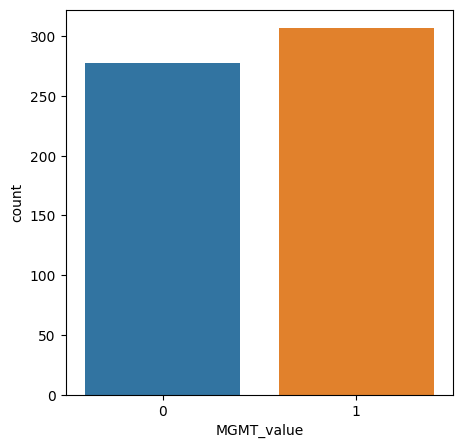

In [73]:
# TODO

plt.figure(figsize=(5, 5))
sns.countplot(data=dataset, x="MGMT_value");

# TODO

# Read Dicom Files

# TODO

# Dataset analysis

# TODO For the team 